In [2]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics, tree
from imblearn.under_sampling import RandomUnderSampler
from shap import plots, Explanation, KernelExplainer
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle
import shap

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest, average='binary'):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain, average = average),
                metricsObj.recall_score(yTrain, yPredTrain, average = average),
                metricsObj.f1_score(yTrain, yPredTrain, average = average),
                metricsObj.roc_auc_score(yTrain, yPredTrain, average = None if average == 'binary' else average)
                ]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest, average = average),
               metricsObj.recall_score(yTest, yPredTest, average = average),
               metricsObj.f1_score(yTest, yPredTest, average = average),
               metricsObj.roc_auc_score(yTest, yPredTest, average = None if average == 'binary' else average)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [4]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

- aggiungere cross validation
- passare a usare i sample
- guardare la dimesione dell'albero
- confrontare sample con dati interi

Here I change the type of some feature becuase since they come from a network package they are supposed to be a certain amount of bit maximum, I also checked before to do the change.

Then I will eclude the ip of the hosts, the port and the Unnamed: 0. Because the ip and ports are categorical but they are to many to fit in the model, and also there is not a good reason for train the model over the ip since it change based on the network so the attacker will always have a different one. About the Unnamed: 0 you can use that number to split this csv in mani csvs which is not a thing that we need to do so I removed that feature as well.

In [5]:
dtype_dict = {
    'Unnamed: 0': 'uint32',
    'uid': 'str',
    'originh': 'category',
    'originp': 'uint16',
    'responh': 'category',
    'responp': 'uint16',
    'flow_duration': 'float64',
    'fwd_pkts_tot': 'uint64',
    'bwd_pkts_tot': 'uint64',
    'fwd_data_pkts_tot': 'uint64',
    'bwd_data_pkts_tot': 'uint64',
    'fwd_pkts_per_sec': 'float64',
    'bwd_pkts_per_sec': 'float64',
    'flow_pkts_per_sec': 'float64',
    'down_up_ratio': 'float32',
    'fwd_header_size_tot': 'uint64',
    'fwd_header_size_min': 'uint8',
    'fwd_header_size_max': 'uint8',
    'bwd_header_size_tot': 'uint64',
    'bwd_header_size_min': 'uint8',
    'bwd_header_size_max': 'uint8',
    'flow_FIN_flag_count': 'uint64',
    'flow_SYN_flag_count': 'uint64',
    'flow_RST_flag_count': 'uint64',
    'fwd_PSH_flag_count': 'uint64',
    'bwd_PSH_flag_count': 'uint64',
    'flow_ACK_flag_count': 'uint64',
    'fwd_URG_flag_count': 'uint64',
    'bwd_URG_flag_count': 'uint64',
    'flow_CWR_flag_count': 'uint64',
    'flow_ECE_flag_count': 'uint64',
    'fwd_pkts_payload.min': 'uint16',
    'fwd_pkts_payload.max': 'uint16',
    'fwd_pkts_payload.tot': 'float64',
    'fwd_pkts_payload.avg': 'float64',
    'fwd_pkts_payload.std': 'float64',
    'bwd_pkts_payload.min': 'uint16',
    'bwd_pkts_payload.max': 'uint16',
    'bwd_pkts_payload.tot': 'float64',
    'bwd_pkts_payload.avg': 'float64',
    'bwd_pkts_payload.std': 'float64',
    'flow_pkts_payload.min': 'uint16',
    'flow_pkts_payload.max': 'uint16',
    'flow_pkts_payload.tot': 'float64',
    'flow_pkts_payload.avg': 'float64',
    'flow_pkts_payload.std': 'float64',
    'fwd_iat.min': 'float64',
    'fwd_iat.max': 'float64',
    'fwd_iat.tot': 'float64',
    'fwd_iat.avg': 'float64',
    'fwd_iat.std': 'float64',
    'bwd_iat.min': 'float64',
    'bwd_iat.max': 'float64',
    'bwd_iat.tot': 'float64',
    'bwd_iat.avg': 'float64',
    'bwd_iat.std': 'float64',
    'flow_iat.min': 'float64',
    'flow_iat.max': 'float64',
    'flow_iat.tot': 'float64',
    'flow_iat.avg': 'float64',
    'flow_iat.std': 'float64',
    'payload_bytes_per_second': 'float64',
    'fwd_subflow_pkts': 'float64',
    'bwd_subflow_pkts': 'float64',
    'fwd_subflow_bytes': 'float64',
    'bwd_subflow_bytes': 'float64',
    'fwd_bulk_bytes': 'float64',
    'bwd_bulk_bytes': 'float64',
    'fwd_bulk_packets': 'float32',
    'bwd_bulk_packets': 'float32',
    'fwd_bulk_rate': 'float64',
    'bwd_bulk_rate': 'float64',
    'active.min': 'float64',
    'active.max': 'float64',
    'active.tot': 'float64',
    'active.avg': 'float64',
    'active.std': 'float64',
    'idle.min': 'float64',
    'idle.max': 'float64',
    'idle.tot': 'float64',
    'idle.avg': 'float64',
    'idle.std': 'float64',
    'fwd_init_window_size': 'uint16',
    'bwd_init_window_size': 'uint16',
    'fwd_last_window_size': 'uint16',
    'traffic_category': 'category',
    'Label': 'bool'
}

selected_features = [
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size", "traffic_category", "Label"
]

In [6]:
ds = pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [7]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555278 entries, 0 to 555277
Data columns (total 81 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   flow_duration             555278 non-null  float64 
 1   fwd_pkts_tot              555278 non-null  uint64  
 2   bwd_pkts_tot              555278 non-null  uint64  
 3   fwd_data_pkts_tot         555278 non-null  uint64  
 4   bwd_data_pkts_tot         555278 non-null  uint64  
 5   fwd_pkts_per_sec          555278 non-null  float64 
 6   bwd_pkts_per_sec          555278 non-null  float64 
 7   flow_pkts_per_sec         555278 non-null  float64 
 8   down_up_ratio             555278 non-null  float32 
 9   fwd_header_size_tot       555278 non-null  uint64  
 10  fwd_header_size_min       555278 non-null  uint8   
 11  fwd_header_size_max       555278 non-null  uint8   
 12  bwd_header_size_tot       555278 non-null  uint64  
 13  bwd_header_size_min       555

In [8]:
ds.describe()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,555278.000000,555278.000000,555278.000000
mean,9.306544,18.264091,18.892578,7.956928,15.803417,1720.704202,1674.140666,3394.844869,0.887003,6.361381e+02,19.901433,24.607501,5.754280e+02,16.545190,19.689366,0.562095,0.923988,0.503098,7.084219,10.782839,34.937831,0.001439,0.000011,0.002329,0.000038,22.699050,207.591415,1.872353e+03,52.682038,56.488003,31.246709,1252.857824,2.659391e+04,309.276711,363.239480,22.705447,1263.603752,2.846627e+04,186.045581,299.247061,8.932046e+05,5.102050e+06,9.134269e+06,1.190675e+06,9.329549e+05,1.528412e+04,4.232945e+06,7.234529e+06,3.454519e+05,9.634418e+05,8.937461e+05,5.202171e+06,9.312579e+06,1.080620e+06,7.082713e+05,3.516315e+04,12.653119,13.143448,1507.875699,1.592495e+04,18.984345,6.423852e+03,0.030403,2.513407,1.248447e+03,5.797473e+06,6.405506e+05,8.806241e+05,9.996375e+05,7.352865e+05,1.335883e+05,3.490637e+06,5.000630e+06,8.312942e+06,4.073219e+06,7.992576e+05,14750.725718,21005.879513,4546.872210
std,101.802730,463.901484,469.078877,73.441224,467.349374,4994.579973,4548.503983,9316.856663,0.511737,1.762560e+04,12.524893,16.577095,1.495092e+04,12.151789,15.924656,0.825811,1.018941,0.898075,73.276271,173.178129,932.467347,0.038844,0.003287,0.057376,0.006710,33.855436,287.060480,2.229359e+04,53.300571,89.671573,48.048751,2778.113834,4.004711e+05,569.643855,648.563051,33.867741,2774.930843,4.038744e+05,286.173780,524.095261,7.145073e+06,2.315940e+07,1.017571e+08,7.273388e+06,4.779988e+06,2.570718e+05,2.217501e+07,7.332596e+07,1.682992e+06,4.913081e+06,7.144566e+06,2.323061e+07,1.018055e+08,7.190908e+06,3.437376e+06,2.183837e+05,85.057715,89.297659,17077.706573,1.484343e+05,872.755605,

In [9]:
ds.columns

Index(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd

We can see from this graph that we don't have highly correlated features.

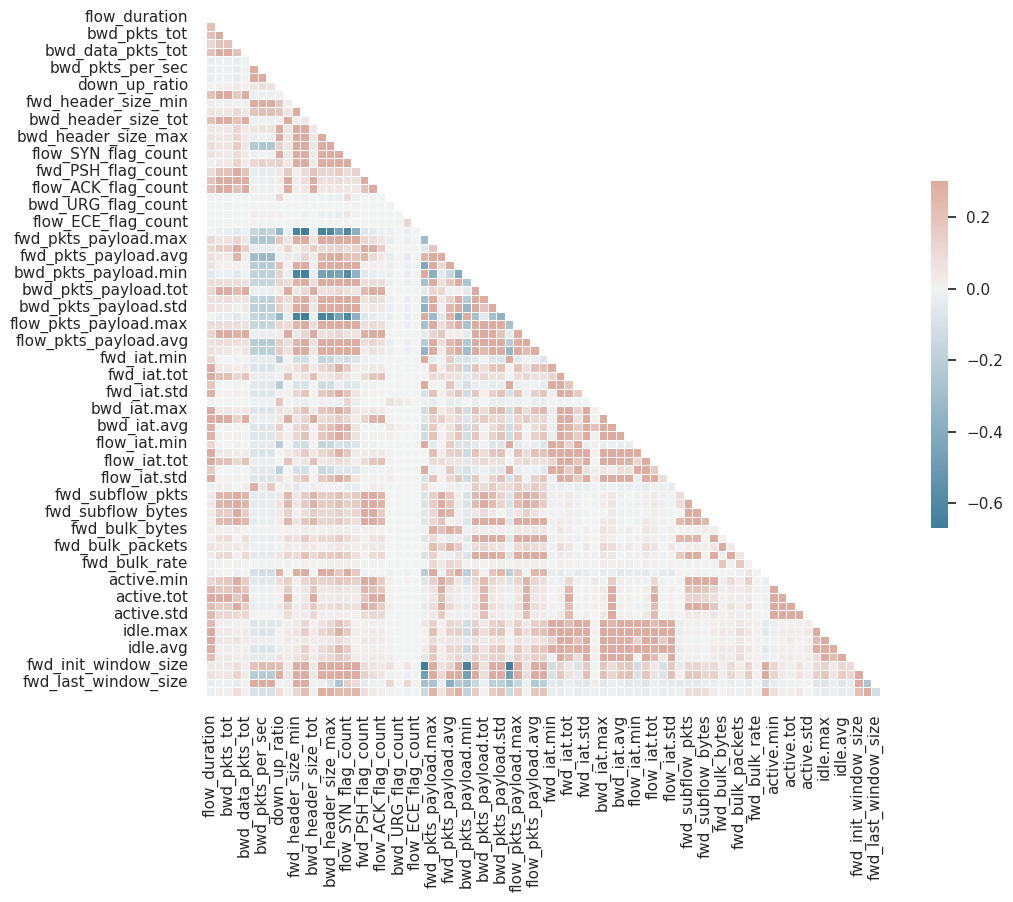

In [10]:
def show_corr_matrix():
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = ds.loc[:, ds.columns != 'traffic_category'].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
show_corr_matrix()

In [11]:
def compute_ratio(data):
    # Get ratio instead of raw numbers using normalize=True
    ratio = data['traffic_category'].value_counts(normalize=True)

    # Round and then convert to percentage
    ratio = ratio.round(4)*100

    # convert to a DataFrame and store in variable 'traffic_category_ratios'
    # We'll use this variable to compare ratios for samples 
    # selected using SRS and Stratified Sampling 
    traffic_category_ratios = pd.DataFrame({'Ratio':ratio})
    print(traffic_category_ratios)
    
compute_ratio(ds)

                     Ratio
traffic_category          
Benign               62.57
Background           30.64
Probing               4.21
Bruteforce            1.06
Bruteforce-XML        0.93
XMRIGCC CryptoMiner   0.59


In [12]:
x_features = [    
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size"
]

In [13]:
sampling_weights = {'Background': 6558, 'Benign': 6558, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}

rus = RandomUnderSampler(random_state=2, sampling_strategy=sampling_weights)
X_res, y_res = rus.fit_resample(ds[x_features], ds.traffic_category)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=ds.loc[y_res.index].traffic_category)

This random forest with max depth 6 is better then any other max depth, and by descreasing the number of estimator to two we can see that the f1 is still 0,96 

In [63]:
# bisognerebbe vedere quale f1 usare
n_estimators = 36
abc = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)

%time cv_results = cross_validate(abc, X_res, ds.loc[y_res.index].Label, scoring='f1', cv=10, verbose=1, n_jobs=-1)
%time abc.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.0s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.5s finished


CPU times: user 244 ms, sys: 242 ms, total: 486 ms
Wall time: 11.5 s
CPU times: user 3.07 s, sys: 0 ns, total: 3.07 s
Wall time: 3.07 s


AdaBoostClassifier(n_estimators=36, random_state=0)

In [64]:
# Plot the learning curve
#cv = 10
#visualizer = LearningCurve(estimator=rf, cv=cv, scoring='f1', n_jobs=-1, random_state=123)
#visualizer.fit(X_train, y_train)
#visualizer.show()

In [65]:
cv_results['test_score']

array([0.97817908, 0.97824456, 0.98306361, 0.98792453, 0.97777778,
       0.90272918, 0.90058885, 0.89838099, 0.89518607, 0.90389252])

In [66]:
cv_results['test_score'].mean()

0.9405967163098911

In [67]:
cv_results['test_score'].std()

0.040597606424562234

In [68]:
%time y_predicted_train = abc.predict(X_train)
%time y_predicted_test = abc.predict(X_test)

CPU times: user 137 ms, sys: 152 µs, total: 137 ms
Wall time: 137 ms
CPU times: user 47.7 ms, sys: 0 ns, total: 47.7 ms
Wall time: 47.3 ms


In [69]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.935811,0.937869
1,PRECISION,0.889315,0.894033
2,RECALL,0.995520,0.993521
3,F1 SCORE,0.939425,0.941155
4,AUC,0.935814,0.937859


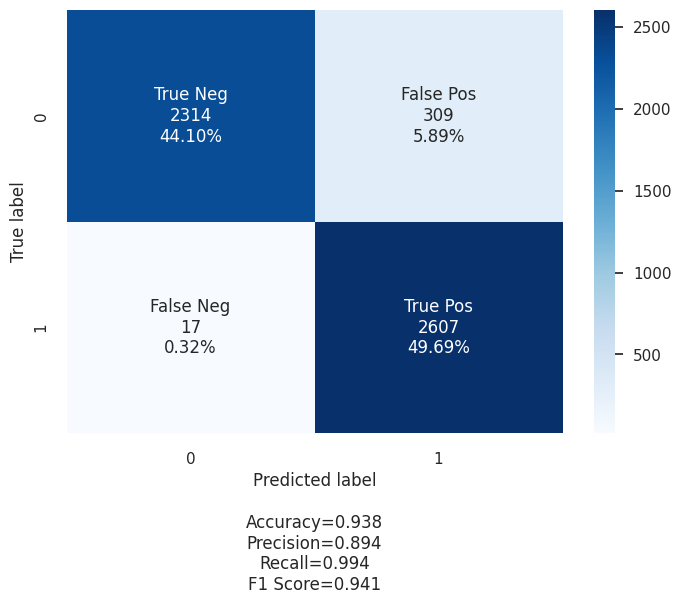

In [70]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [71]:
abc.feature_names_in_

array(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot',
       'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_per_sec',
       'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio',
       'fwd_header_size_tot', 'fwd_header_size_min',
       'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max',
       'flow_FIN_flag_count', 'flow_SYN_flag_count',
       'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count',
       'flow_ACK_flag_count', 'fwd_URG_flag_count', 'bwd_URG_flag_count',
       'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max',
       'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg',
       'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot',
       'bwd_pkts_payload.avg', 'bwd_pkts_payload.std',
       'flow_pkts_payload.min', 'flow_pkts_payload.max',
       'flow_pkts_payload.tot', 'flow_pkts_payload.avg',
       '

In [90]:
feature_importance_dict = dict(zip(x_features, abc.feature_importances_))
important_features = [feature for feature, importance in feature_importance_dict.items() if importance > 0]
pd.DataFrame(data={'features': important_features}).to_csv('abc_data/features_used.csv')

In [23]:
for num, clf in enumerate(abc.estimators_):
    dot_data = tree.export_graphviz(clf, feature_names=x_features, out_file=None, ) 
    graph = graphviz.Source(dot_data)
    graph.render('abc_data/tree/tree_abc_' + str(num))

In [24]:
start_time = time.time()
importances = abc.feature_importances_
std = np.std([tree.feature_importances_ for tree in abc.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.003 seconds


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


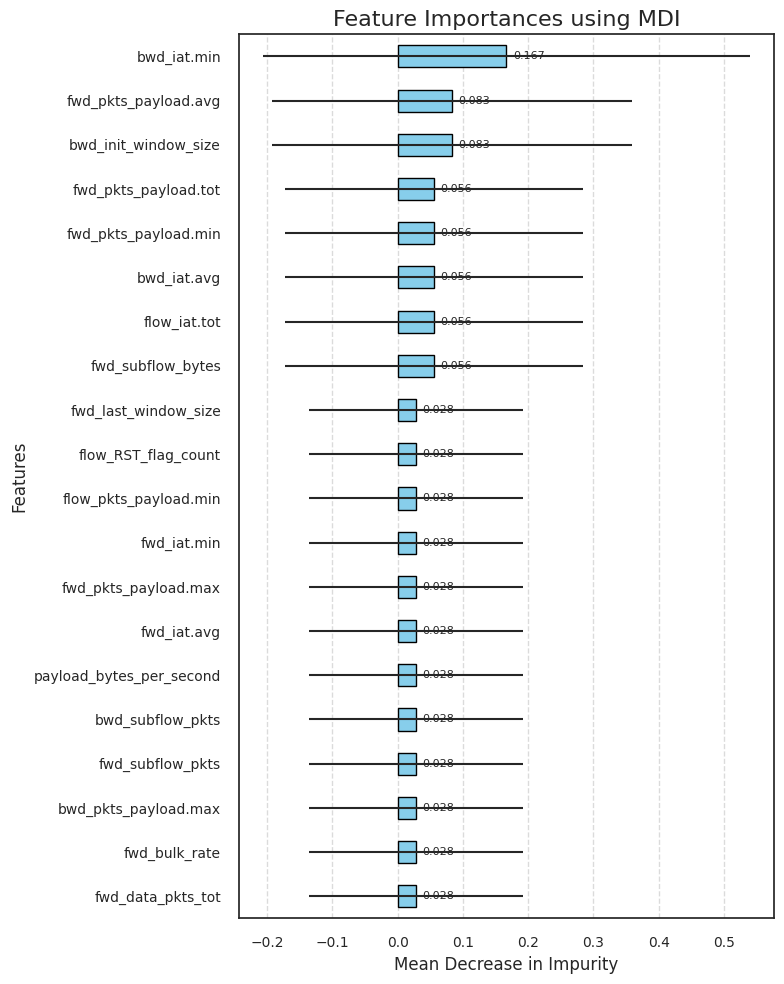

In [25]:
forest_importances = pd.Series(importances, index=x_features)

sorted_indices = np.argsort(forest_importances)[::-1]
sorted_std = std[sorted_indices][:20] # Select only the first 20 features
sorted_importance = forest_importances[sorted_indices][:20]  # Select importance values for the first 20 features

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))  # Adjust the figure size as needed for vertical display

# Create the vertical bar plot with error bars
sorted_importance.plot(kind='barh', xerr=sorted_std, ax=ax, color='skyblue', edgecolor='black')

# Set plot title and labels
ax.set_title("Feature Importances using MDI", fontsize=16)
ax.set_xlabel("Mean Decrease in Impurity", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Invert y-axis to display most important feature at the top
ax.invert_yaxis()

# Add data labels at the end of each bar
for i, v in enumerate(sorted_importance):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

In [92]:
if False:
    print("making exp")
    scaler = StandardScaler()
    scaled_ds = scaler.fit_transform(X_train)

    kmeans = KMeans(n_clusters=1000, random_state=0).fit(scaled_ds)

    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    
    foreground = shap.sample(X_train, 1000)

    explainer = KernelExplainer(abc.predict, centroids)
    sv = explainer.shap_values(foreground)

    exp = Explanation(sv,
                  explainer.expected_value,
                  data=foreground, 
                  feature_names=x_features)

    exp.base_values = np.array([exp.base_values])

    with open('abc_data/exp.pickle', 'wb') as handle:
        pickle.dump(exp, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("loading exp")
    with open('abc_data/exp.pickle', 'rb') as handle:
        exp = pickle.load(handle)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1000/1000 [7:00:46<00:00, 25.25s/it] 


In [34]:
if False:
    scaler = StandardScaler()
    scaled_ds = scaler.fit_transform(ds[x_features])

    kmeans = KMeans(n_clusters=100, random_state=0).fit(scaled_ds)
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)

    exp_list = []

    for k in range(10):
        foreground = shap.sample(X_train, 100)

        explainer = KernelExplainer(abc.predict, centroids)
        sv = explainer.shap_values(foreground)

        exp = Explanation(sv,
                      explainer.expected_value,
                      data=foreground, 
                      feature_names=x_features)

        exp.base_values = np.array([exp.base_values])
        exp_list.append(exp)
        
    with open('abc_data/exp_list.pickle', 'wb') as handle:
        pickle.dump(exp_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("jumping the test")

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
100%|██████████| 100/100 [05:05<00:00,  3.05s/it]


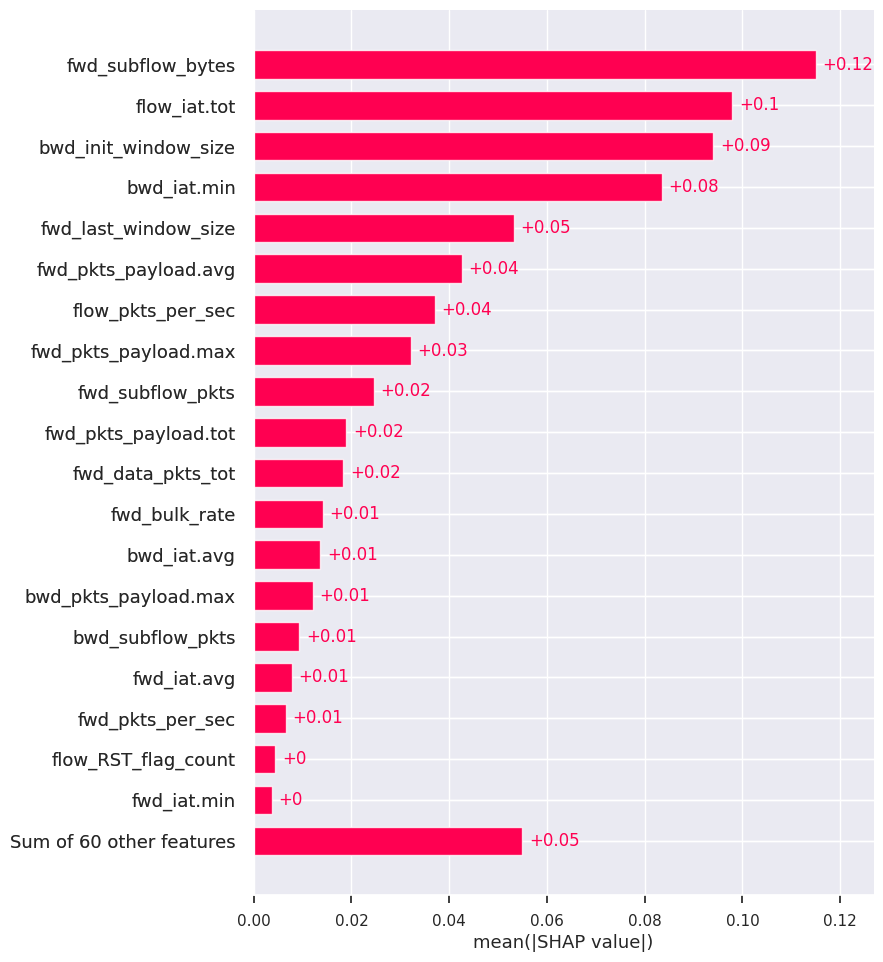

In [97]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

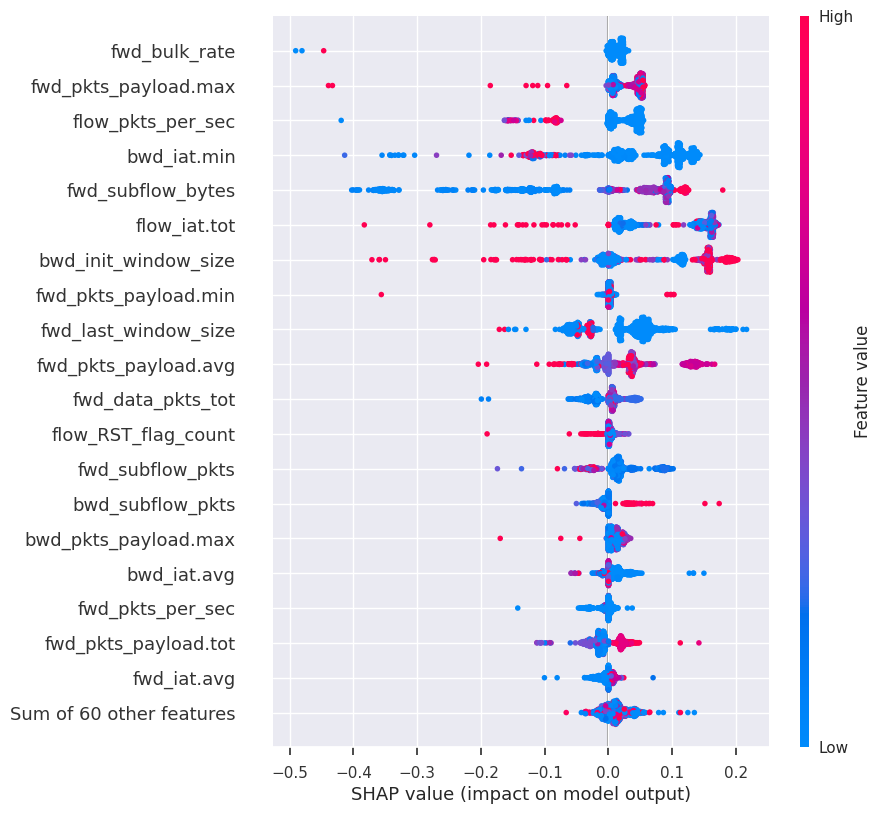

In [98]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

In [99]:
feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
58,0.115072,fwd_subflow_bytes
52,0.097916,flow_iat.tot
77,0.094065,bwd_init_window_size
45,0.083499,bwd_iat.min
78,0.053279,fwd_last_window_size
28,0.042578,fwd_pkts_payload.avg
7,0.037100,flow_pkts_per_sec
26,0.032145,fwd_pkts_payload.max
56,0.024587,fwd_subflow_pkts
27,0.018934,fwd_pkts_payload.tot


In [100]:
feature_importance.to_csv('abc_data/feature_importance.csv')

In [41]:
feature_above_zero = feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [42]:
%%time

def get_score(features):
    start_cv = time.time()
    cv_results = cross_validate(abc, X_res[features], ds.loc[y_res.index].Label, scoring='f1', cv=10, verbose=1, n_jobs=-1)
    end_cv = time.time()
    return cv_results['test_score'].mean(),cv_results['test_score'].std(), len(features), end_cv - start_cv

def recursive_reduction():
    scores = []
    score_std = []
    n_features = []
    cv_time = []
    
    # making a warm up run otherwise the first one will be always slower than the others
    # only one features so that it can be as fast as possibile
    get_score(['fwd_iat.tot'])
    
    result = get_score(feature_above_zero)
    scores.append(result[0])
    score_std.append(result[1])
    n_features.append(result[2])
    cv_time.append(result[3]) 
    
    for i in range(1,len(feature_above_zero)):
        result = get_score(feature_above_zero[:-i])
        scores.append(result[0])
        score_std.append(result[1])
        n_features.append(result[2])
        cv_time.append(result[3])
        
    return scores, score_std, n_features, cv_time

result = recursive_reduction()
feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.4s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.4s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.0s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

CPU times: user 9.79 s, sys: 5.12 s, total: 14.9 s
Wall time: 8min 21s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished


In [43]:
with open('abc_data/feature_reduction_scores.pickle', 'wb') as handle:
    pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

<Axes: xlabel='n_features', ylabel='cv_time'>

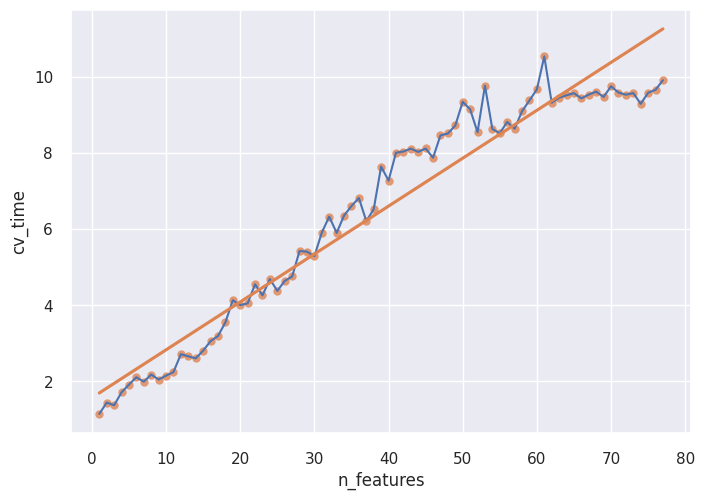

In [44]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

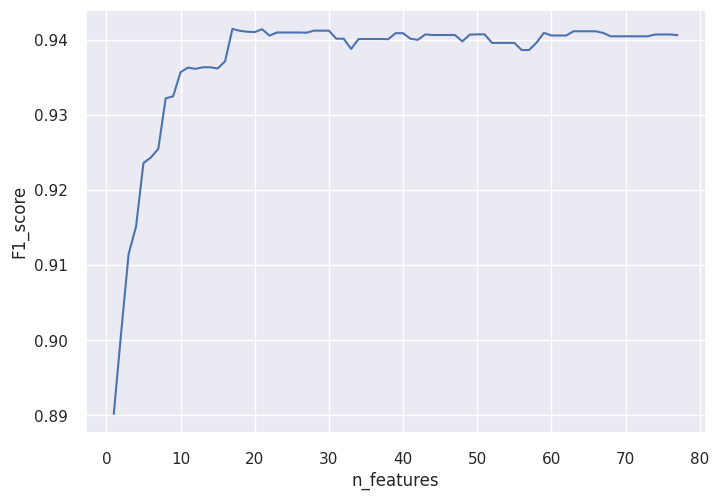

In [45]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

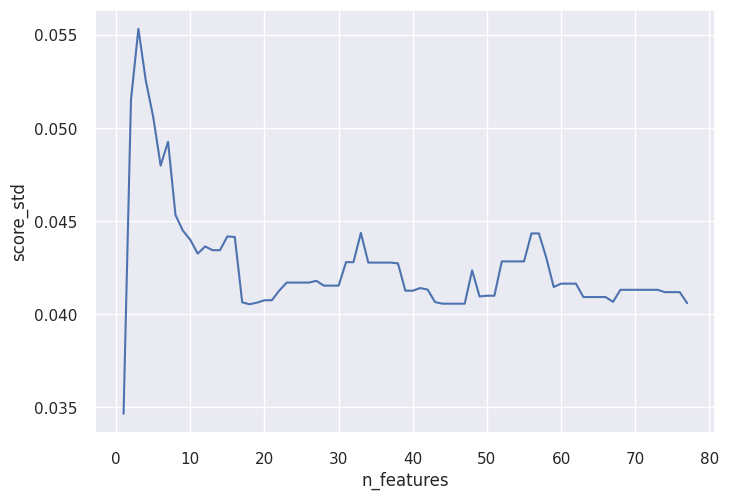

In [46]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [47]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
60,0.941428,0.040644,17,3.191351
56,0.941382,0.040760,21,4.049280
48,0.941190,0.041543,29,5.405993
47,0.941190,0.041543,30,5.286546
49,0.941190,0.041543,28,5.422818
...,...,...,...,...
72,0.923583,0.050599,5,1.917377
73,0.915129,0.052549,4,1.715486
74,0.911486,0.055330,3,1.375796
75,0.901085,0.051514,2,1.444618


Here we can have zero on the results of f1 and recall that means that the model has failed to detect the attack, while the cross validation result is usefull only to see how well the model is scoring with all the data except the one regarding the attack

In [48]:
# add also training time
attack_f1 = []
attack_recall = []
attack_precision = []
cv_score_avg = []
cv_score_std = []
n_features = []
attacks = []
fit_time = []
pred_time = []

# warmup boolean, this variable will be used to load in memory the function in order to have reliable time measures
warmup = True

def test_zero_day(attack, features, rus, rus_attack):
    global warmup
    
    X_res, y_res = rus.fit_resample(ds[features], ds.traffic_category)
    y_res = ds.loc[y_res.index].Label
    
    X_attack, y_attack = rus_attack.fit_resample(ds[features], ds.traffic_category)
    y_attack = ds.loc[y_attack.index].Label
    
    cv_results = cross_validate(abc, X_res, y_res, scoring='f1', cv=10, verbose=0, n_jobs=-1)
    
    if warmup:
        abc.fit(X_res,y_res)
        abc.predict(X_attack)
    
    start_fit = time.time()
    abc.fit(X_res,y_res)
    end_fit = time.time()
    
    start_pred = time.time()
    y_predicted = abc.predict(X_attack)
    end_pred = time.time()
    
    attack_f1.append(metrics.f1_score(y_attack, y_predicted))
    attack_recall.append(metrics.recall_score(y_attack, y_predicted))
    attack_precision.append(metrics.precision_score(y_attack, y_predicted))
    cv_score_avg.append(cv_results['test_score'].mean())
    cv_score_std.append(cv_results['test_score'].std())
    n_features.append(len(features))
    attacks.append(attack)
    fit_time.append(end_fit - start_fit)
    pred_time.append(end_pred - start_pred)

    # at the very first iteration we change it to false
    warmup = False
    
def recursive_reduction(attack):
    # making a sample for having a 1:1 ration for positive and negative class
    # keep in mind that in the training I will have only three attacks, while for the test only one attack
    sampling_weights = {'Background': 4918, 'Benign': 4918, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}
    sampling_attack = {'Background': 1638, 'Benign': 1638, 'XMRIGCC CryptoMiner': 0, 'Probing': 0, 'Bruteforce': 0, 'Bruteforce-XML': 0}
    
    # removing all the attack observations
    sampling_weights[attack] = 0
    
    # doing the undersampling
    rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
    
    # adding the attack to the test dataset with the non attack traffic
    sampling_attack[attack] = 3279
    
    # making the dataset with only one attack
    rus_attack = RandomUnderSampler(random_state=42, sampling_strategy=sampling_attack)
    
    test_zero_day(attack, feature_above_zero, rus, rus_attack)
    
    for i in range(1,len(feature_above_zero)):
        test_zero_day(attack, feature_above_zero[:-i], rus, rus_attack)
        
for attack in ['XMRIGCC CryptoMiner','Probing','Bruteforce','Bruteforce-XML']:
    print('traing for ', attack)
    %time recursive_reduction(attack)
    
zero_day_feature_reduction_scores = pd.DataFrame({'attack_f1': attack_f1,  'attack_recall': attack_recall, 'attack_precision': attack_precision, 'cv_score_avg': cv_score_avg, 'cv_score_std': cv_score_std, 'n_features': n_features, 'attack_name': attacks, 'fit_time': fit_time, 'pred_time': pred_time})

traing for  XMRIGCC CryptoMiner
CPU times: user 7min 9s, sys: 4.12 s, total: 7min 13s
Wall time: 13min 14s
traing for  Probing
CPU times: user 6min 23s, sys: 3.8 s, total: 6min 27s
Wall time: 11min 36s
traing for  Bruteforce
CPU times: user 6min 22s, sys: 3.79 s, total: 6min 26s
Wall time: 11min 20s
traing for  Bruteforce-XML
CPU times: user 6min 39s, sys: 3.85 s, total: 6min 42s
Wall time: 11min 52s


In [49]:
with open('abc_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
    pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [51]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
76,0.892123,0.972248,0.824199,0.898577,0.031155,1,XMRIGCC CryptoMiner,0.237693,0.022320,1
230,0.847453,0.880146,0.817101,0.895972,0.032803,1,Bruteforce,0.237843,0.022171,1
307,0.667348,0.597133,0.756277,0.900919,0.031164,1,Bruteforce-XML,0.386484,0.030962,1
306,0.682961,0.596523,0.798693,0.913360,0.035474,2,Bruteforce-XML,0.429111,0.051005,1
303,0.639723,0.535834,0.793586,0.926574,0.038173,5,Bruteforce-XML,0.595956,0.057862,1
...,...,...,...,...,...,...,...,...,...,...
270,0.000545,0.000305,0.002551,0.942135,0.036873,38,Bruteforce-XML,1.557211,0.028613,1
271,0.000545,0.000305,0.002551,0.942092,0.036904,37,Bruteforce-XML,1.602965,0.028265,1
272,0.000545,0.000305,0.002551,0.942092,0.036904,36,Bruteforce-XML,1.539737,0.030108,1
273,0.000545,0.000305,0.002551,0.942092,0.036904,35,Bruteforce-XML,1.445685,0.026762,1


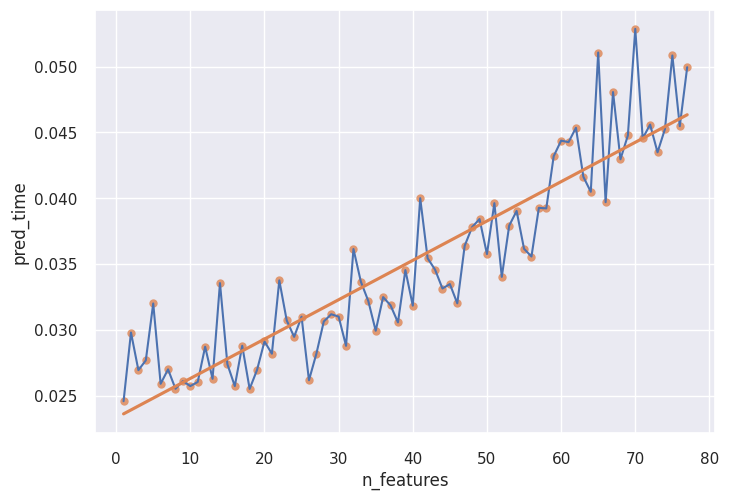

In [52]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

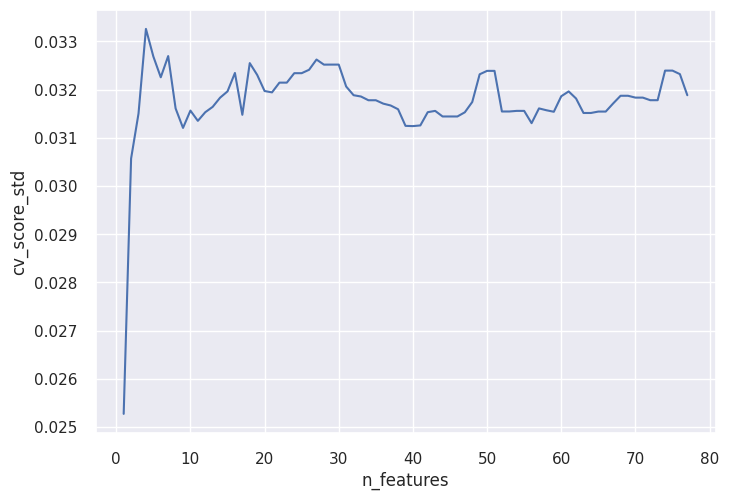

In [53]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [54]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
1,0.628443,0.627783,0.699992,0.909839,0.025274,0.272331,0.024585,1.00
5,0.259607,0.203416,0.375073,0.941431,0.032689,0.455095,0.032007,0.75
2,0.189656,0.160034,0.271031,0.933372,0.030571,0.305134,0.029800,0.50
3,0.176872,0.136627,0.289739,0.934973,0.031505,0.345745,0.026943,0.50
4,0.157847,0.120311,0.258606,0.934808,0.033262,0.457957,0.027685,0.50
...,...,...,...,...,...,...,...,...
17,0.014498,0.008310,0.058292,0.953249,0.031479,0.709117,0.028794,0.75
47,0.014258,0.008158,0.056547,0.952927,0.031531,1.867884,0.036396,0.50
18,0.005558,0.003126,0.026423,0.952202,0.032551,0.796710,0.025519,0.50


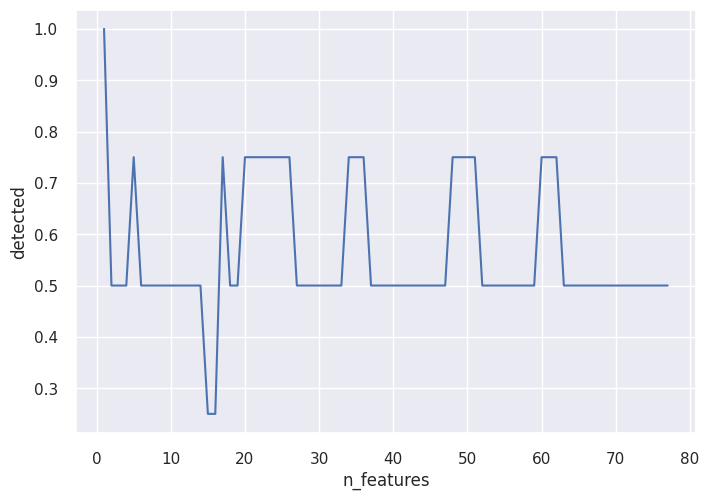

In [55]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

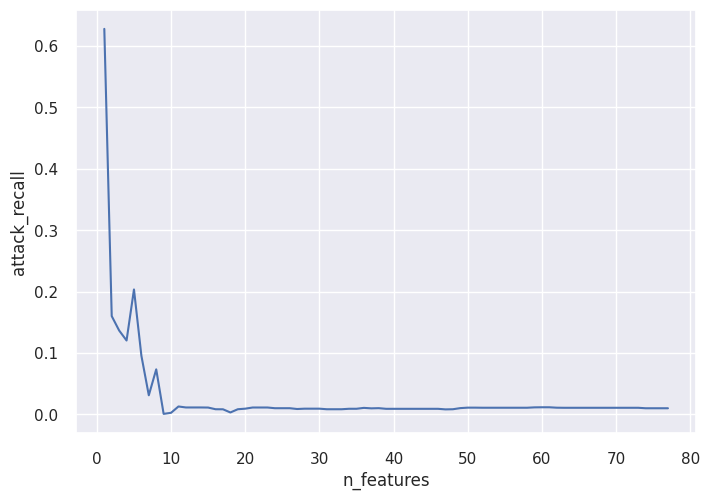

In [56]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [57]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
1,0.628443,0.627783,0.699992,0.909839,0.025274,0.272331,0.024585
5,0.259607,0.203416,0.375073,0.941431,0.032689,0.455095,0.032007
2,0.189656,0.160034,0.271031,0.933372,0.030571,0.305134,0.029800
3,0.176872,0.136627,0.289739,0.934973,0.031505,0.345745,0.026943
4,0.157847,0.120311,0.258606,0.934808,0.033262,0.457957,0.027685
...,...,...,...,...,...,...,...
17,0.014498,0.008310,0.058292,0.953249,0.031479,0.709117,0.028794
47,0.014258,0.008158,0.056547,0.952927,0.031531,1.867884,0.036396
18,0.005558,0.003126,0.026423,0.952202,0.032551,0.796710,0.025519


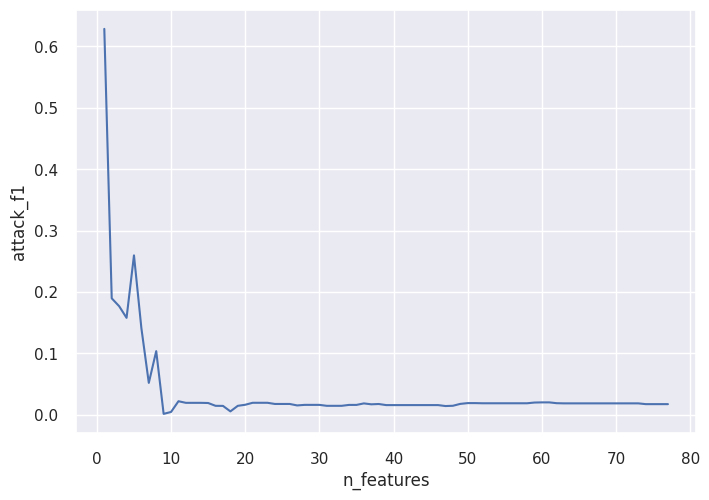

In [58]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [59]:
zero_day_feature_reduction_scores.query('n_features == 1')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
76,0.892123,0.972248,0.824199,0.898577,0.031155,1,XMRIGCC CryptoMiner,0.237693,0.022320,1
153,0.106850,0.061604,0.402390,0.943886,0.005973,1,Probing,0.227305,0.022887,1
230,0.847453,0.880146,0.817101,0.895972,0.032803,1,Bruteforce,0.237843,0.022171,1
307,0.667348,0.597133,0.756277,0.900919,0.031164,1,Bruteforce-XML,0.386484,0.030962,1


In [60]:
zero_day_feature_reduction_scores.query('n_features == 79')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
